In [1]:
import os, sys
import pandas as pd

sys.path.append("../model_explorer/third_party/yolop_det_seg")

from model_explorer.result_handling.collect_results import collect_results

In [2]:
WORKLOAD = 'deeplab'

if WORKLOAD == 'unet':
    results = collect_results('/home/oq4116/projekte/ai-hardware-accelerators/mixed-precision-dnns/results/expl_energy_aware_quant_problem_unet_david_2023-03-30_20-29.pkl')
if WORKLOAD == 'yolop':
    results = collect_results('/home/oq4116/projekte/ai-hardware-accelerators/mixed-precision-dnns/results/energy_aware_yolop/expl_energy_aware_quant_problem_yolop_bdd100k_2023-03-30_13-53.pkl')
if WORKLOAD == 'deeplab':
    results = collect_results('/home/oq4116/projekte/ai-hardware-accelerators/mixed-precision-dnns/results/expl_energy_aware_quant_problem_deeplabv3_cityscapes_2023-04-05_19-57.pkl')

dfin = results.to_dataframe()

dfin.head()


Backbone HRNet Pretrained weights at: ./checkpoints/hrnetv2_32_model_best_epoch96.pth, only usable for HRNetv2-32


,generation,individual,accuracies,mutation_eta,mutation_prob,crossover_eta,crossover_prob,selection_press,F_0,parameters
0,0,0,[0.9446534016517839],10,1.0,5,0.9,2,49547.525038,"[9, 12, 9, 12, 7, 6, 14, 11, 7, 10, 14, 5, 5, ..."
1,0,1,[0.9359360051899434],10,1.0,5,0.9,2,55962.937100,"[8, 13, 10, 12, 9, 9, 12, 5, 10, 13, 9, 6, 12,..."
2,0,2,[0.915563156331752],10,1.0,5,0.9,2,72288.788563,"[7, 13, 10, 11, 9, 10, 7, 4, 10, 7, 9, 13, 8, ..."
3,0,3,[0.9266285527638636],10,1.0,5,0.9,2,82523.326450,"[12, 10, 14, 10, 6, 8, 7, 14, 8, 14, 9, 6, 5, ..."
4,0,4,[0.8863642348714504],10,1.0,5,0.9,2,91808.528625,"[6, 7, 7, 12, 12, 8, 10, 5, 9, 7, 13, 11, 10, ..."


In [3]:
def prepare(df):
    if WORKLOAD == 'yolop':
        df[['acc_ll','acc_da','acc_det']] = pd.DataFrame(df.accuracies.tolist(), index=df.index)
        df = df[df['acc_ll'] > results.accuracy_limit[0]]
        df = df[df['acc_da'] > results.accuracy_limit[1]]
        df = df[df['acc_det'] > results.accuracy_limit[2]] 
        df['combined'] = df['acc_ll'] / max(df['acc_ll']) + df['acc_da'] / max(df['acc_da']) + df['acc_det'] / max(df['acc_det'])
    if WORKLOAD == 'unet':
        df[['acc_miou']] = pd.DataFrame(df.accuracies.tolist(), index=df.index)
        df = df[df['acc_miou'] > results.accuracy_limit]
    if WORKLOAD == 'deeplab':
        df[['acc_pixel']] = pd.DataFrame(df.accuracies.tolist(), index=df.index)
        df = df[df['acc_pixel'] > results.accuracy_limit]

    return df

df_prep = prepare(dfin)
print(df_prep.shape)
df_prep.head()

(242, 11)


,generation,individual,accuracies,mutation_eta,mutation_prob,crossover_eta,crossover_prob,selection_press,F_0,parameters,acc_pixel
0,0,0,[0.9446534016517839],10,1.0,5,0.9,2,49547.525038,"[9, 12, 9, 12, 7, 6, 14, 11, 7, 10, 14, 5, 5, ...",0.944653
1,0,1,[0.9359360051899434],10,1.0,5,0.9,2,55962.937100,"[8, 13, 10, 12, 9, 9, 12, 5, 10, 13, 9, 6, 12,...",0.935936
2,0,2,[0.915563156331752],10,1.0,5,0.9,2,72288.788563,"[7, 13, 10, 11, 9, 10, 7, 4, 10, 7, 9, 13, 8, ...",0.915563
3,0,3,[0.9266285527638636],10,1.0,5,0.9,2,82523.326450,"[12, 10, 14, 10, 6, 8, 7, 14, 8, 14, 9, 6, 5, ...",0.926629
20,1,0,[0.9299169682540575],10,1.0,5,0.9,2,48883.416637,"[9, 13, 11, 11, 6, 6, 14, 11, 7, 12, 9, 6, 6, ...",0.929917


<AxesSubplot: xlabel='Accuracy', ylabel='Energy in uJ'>

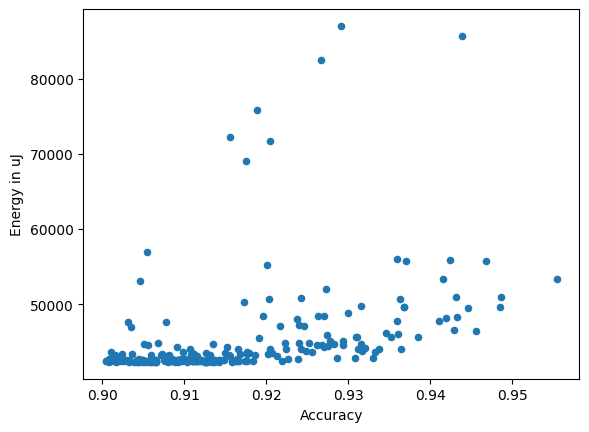

In [4]:
if WORKLOAD == 'yolop':
    x_idx = 'combined'
if WORKLOAD == 'unet':
    x_idx = 'acc_miou'
if WORKLOAD == 'deeplab':
    x_idx = 'acc_pixel'

df_prep.plot(kind='scatter', x=x_idx, y='F_0', xlabel='Accuracy', ylabel='Energy in uJ')


## Return Pareto results for TikZ Plots

In [5]:
def is_pareto_efficient_dumb(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        is_efficient[i] = np.all(np.any(costs[:i]>c, axis=1)) and np.all(np.any(costs[i+1:]>c, axis=1))
    return is_efficient

In [6]:
import numpy as np

points = df_prep[[x_idx, 'F_0']].to_numpy()

pareto_array = is_pareto_efficient_dumb(points)
pareto_array = np.expand_dims(pareto_array, 1)

print(pareto_array.shape, points.shape)

data = np.hstack([points, pareto_array])

for row in data:
    domstr = 'dom' if row[2] == 0 else 'nondom'
    print(f"{row[0]*1:.4f},{row[1]/1000:.4f},{domstr}")

(242, 1) (242, 2)
0.9447,49.5475,dom
0.9359,55.9629,dom
0.9156,72.2888,dom
0.9266,82.5233,dom
0.9299,48.8834,dom
0.9315,49.7605,dom
0.9203,50.6849,dom
0.9242,50.7787,dom
0.9554,53.3431,dom
0.9424,55.8145,dom
0.9054,56.9554,dom
0.9175,69.0725,dom
0.9204,71.7013,dom
0.9188,75.8470,dom
0.9439,85.6366,dom
0.9291,87.0092,dom
0.9429,46.5054,dom
0.9368,49.6558,dom
0.9369,49.6664,dom
0.9172,50.3495,dom
0.9432,50.9405,dom
0.9046,53.1495,dom
0.9416,53.3586,dom
0.9200,55.1796,dom
0.9371,55.6862,dom
0.9468,55.7280,dom
0.9293,45.1721,dom
0.9217,47.1612,dom
0.9241,47.3013,dom
0.9032,47.6584,dom
0.9359,47.8169,dom
0.9433,48.2487,dom
0.9485,49.6432,dom
0.9363,50.7090,dom
0.9487,50.9890,dom
0.9273,52.0851,dom
0.9320,44.1381,dom
0.9051,44.6501,dom
0.9223,44.8345,dom
0.9352,45.5945,dom
0.9360,46.0873,dom
0.9246,47.1479,dom
0.9078,47.6520,dom
0.9410,47.7044,dom
0.9238,47.9880,dom
0.9419,48.1588,dom
0.9195,48.4020,dom
0.9271,48.4795,dom
0.9263,48.4932,dom
0.9037,43.3147,dom
0.9091,44.3271,dom
0.9068,44.881

### Generate Bit plot

#### Extract layers

In [69]:
# layer_df = pd.read_csv('layer_list.csv')
# layer_df.head()
energy_df = pd.read_csv('/home/oq4116/projekte/ai-hardware-accelerators/mixed-precision-dnns/results/dram_accesses_yolop.csv')


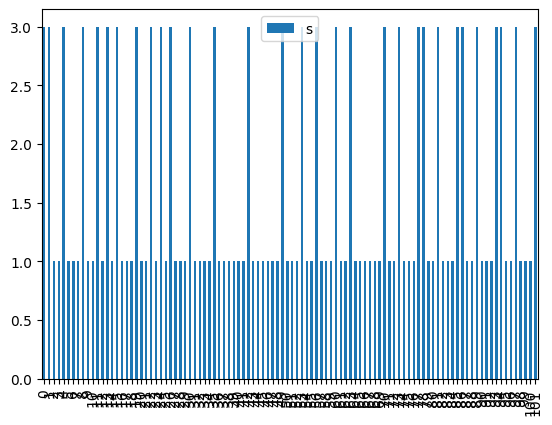

In [36]:
layer_df.plot(kind='bar',y='s')

In [43]:
import numpy as np

# all below an energy threshold
ENERGY_THRESHOLD = 20000

df_constrained = df_prep[df_prep['F_0'] < ENERGY_THRESHOLD]
bit_mat = None

for i, row in df_constrained.iterrows():
    params = np.array(row['parameters'])
    if bit_mat is None:
        bit_mat = params
    else:
        bit_mat = np.vstack((bit_mat, params))

print(bit_mat.shape)

(84, 204)


In [44]:
bits = np.mean(bit_mat, axis=0)

<BarContainer object of 102 artists>

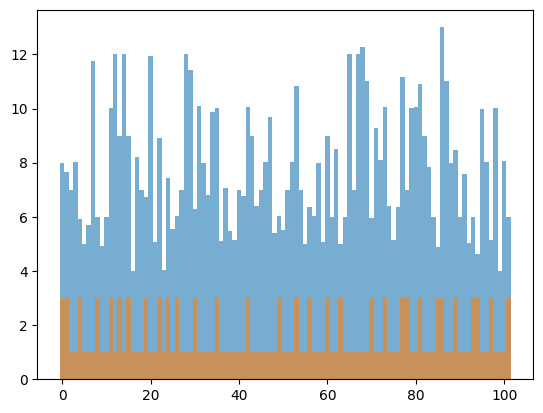

In [45]:
import matplotlib.pyplot as plt

input_bits = bits[0::2]
weight_bits = bits[1::2]

xi = list(range(input_bits.shape[0]))
xw = list(range(weight_bits.shape[0]))
plt.bar(xi, input_bits, width=1, alpha=0.6)
# plt.bar(xw, weight_bits, width=1, alpha=0.6)
plt.bar(xw, d2, width=1, alpha=0.6)

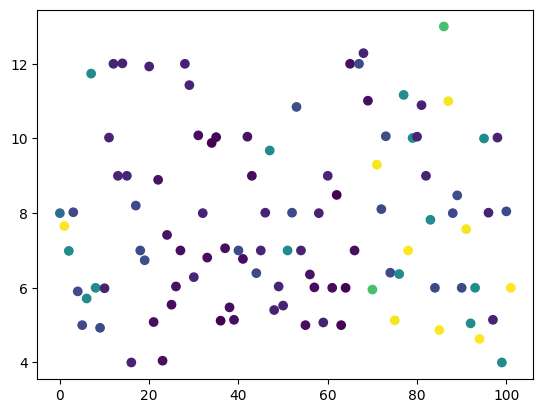

In [73]:
d2 = energy_df['i_reads'].to_numpy()
plt.scatter(x=xw, y=input_bits, c=d2)

In [40]:
print("Inputs:", np.mean(input_bits))
print("Weights:", np.mean(weight_bits))

Inputs: 7.737511671335201
Weights: 8.248366013071896


Combination with the least bits

<BarContainer object of 102 artists>

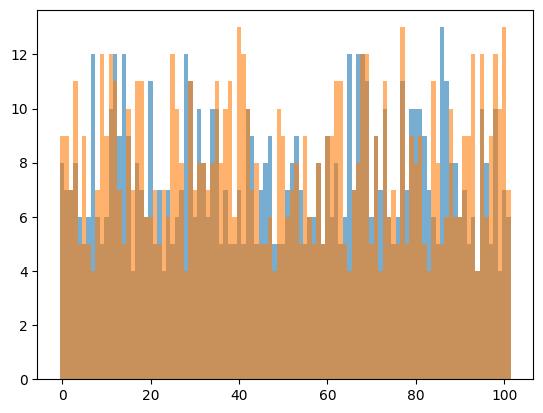

In [41]:
series_best = df_prep.sort_values(by='F_0', ascending=True).iloc[0]
bits = series_best['parameters']

input_bits = bits[0::2]
weight_bits = bits[1::2]

xi = list(range(len(input_bits)))
xw = list(range(len(weight_bits)))
plt.bar(xi, input_bits, width=1, alpha=0.6)
plt.bar(xw, weight_bits, width=1, alpha=0.6)


Export for TikZ plot

In [16]:
def generate_tikz_bits_data(inp_bits, w_bits):
    for i, b in enumerate(inp_bits):
        print(f"({i}, {b:.4f})")
    print("")
    for i, w in enumerate(w_bits):
        print(f"({i}, {-w:.4f})")

(0, 8.0000)
(1, 7.0000)
(2, 7.0000)
(3, 8.0000)
(4, 6.0000)
(5, 5.0000)
(6, 6.0000)
(7, 12.0000)
(8, 6.0000)
(9, 5.0000)
(10, 6.0000)
(11, 10.0000)
(12, 12.0000)
(13, 9.0000)
(14, 12.0000)
(15, 9.0000)
(16, 4.0000)
(17, 8.0000)
(18, 7.0000)
(19, 6.0000)
(20, 11.0000)
(21, 5.0000)
(22, 7.0000)
(23, 4.0000)
(24, 7.0000)
(25, 5.0000)
(26, 6.0000)
(27, 7.0000)
(28, 12.0000)
(29, 11.0000)
(30, 6.0000)
(31, 10.0000)
(32, 8.0000)
(33, 6.0000)
(34, 10.0000)
(35, 10.0000)
(36, 5.0000)
(37, 7.0000)
(38, 5.0000)
(39, 5.0000)
(40, 7.0000)
(41, 5.0000)
(42, 10.0000)
(43, 9.0000)
(44, 5.0000)
(45, 7.0000)
(46, 8.0000)
(47, 9.0000)
(48, 5.0000)
(49, 5.0000)
(50, 5.0000)
(51, 7.0000)
(52, 8.0000)
(53, 9.0000)
(54, 7.0000)
(55, 5.0000)
(56, 6.0000)
(57, 6.0000)
(58, 8.0000)
(59, 5.0000)
(60, 9.0000)
(61, 6.0000)
(62, 8.0000)
(63, 5.0000)
(64, 6.0000)
(65, 12.0000)
(66, 7.0000)
(67, 12.0000)
(68, 12.0000)
(69, 11.0000)
(70, 6.0000)
(71, 9.0000)
(72, 7.0000)
(73, 10.0000)
(74, 6.0000)
(75, 5.0000)
(76, 6